**классификатор текстов LSTM**

с сортировкой по длинне строк при формировании батчей

Евгений Борисов <esborisov@sevsu.ru>

https://habr.com/ru/company/dca/blog/274027/    
http://help.sentiment140.com/for-students/   
http://study.mokoron.com  

## Библиотеки

In [1]:
import numpy as np
import numpy.random as rng

import pandas as pd
pd.options.display.max_colwidth = 200  
import re
# import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
# from torchviz import make_dot

In [3]:
torch.__version__

'1.8.1'

In [4]:
tqdm.pandas()

In [5]:
def pp(d): return "{:,.0f}".format(d).replace(",", " ")
def ppr(d): print('записей:', pp(len(d)) )  

## Данные

In [6]:
ff = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount','unk']

In [7]:
neg = pd.read_csv('../data/twit/negative.csv.gz',sep=';',header=None)
ppr(neg)
neg.columns = ff

записей: 111 923


In [8]:
pos = pd.read_csv('../data/twit/positive.csv.gz',sep=';')
ppr(pos)
pos.columns = ff

записей: 114 910


In [9]:
data = pd.concat([pos,neg],sort=False)[['id','ttext', 'ttype']]
ppr(data)

записей: 226 833


In [10]:
data.sample(10)

,id,ttext,ttype
35447,409775550434394112,"@ololoshq из всех твоих сестер по папиной линии,я люблю Дагмару :)",1
34196,409764231551000576,Лілі захотілось всістись мені наруки)вона думає шо вона пушинкаа)),1
73887,410627165659869184,Вот уж действительно - неожиданная встреча)) http://t.co/h47a7XHfeX,1
18313,411435256953470976,"ТВИТТЕРСКИЕ: да я в шк сижу на уроке;(\nЯ: ТЫ ЧТО ЕБАНУТЫЙ, ТЫ ЧТО ТАМ ДЕЛАЕШЬ?!\nВИНОВАТА #пятница13",-1
42067,409938310350790656,у блендернейшена фальстарт с анонсом blemder 2.62 :),1
39412,409897630911975424,RT @fileryzofos: Эта хуита таки сломалась! %) Теперь не получается писать сообщения с картинками. :),1
801,408915796610412544,"@Alexander_ae_ я узнаю об этом только, если постигну учение дзынь-мынь, но такого не постичь. поэтому буду думать, что все таки шейх)",1
35703,409777801340792832,я так давно [неделю] не играл с Боунси\nчто отвык писать большие посты\nугадайте кому стыдно ?\nну ничего\nсейчас опять привыкнем х),1
74850,418716504037666816,"@kannizllg От безделия решила установить Sims3, пол вечера мучаюсь решая проблему с обновлениями((((",-1
110336,411193924209115136,@Mityaforyou @Unicorn_Nevpaty Она давно прошла уже),1


## очистка данных

In [11]:
data['ttext_clean'] = data['ttext']\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t:[ re.sub(r'^http.*',' url ', w.strip() ) for w in t ] )\
    .progress_apply(lambda t:[ re.sub(r'[:;]-*[)D]',' happysmile ', w.strip() )for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\)\)\)*',' happysmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'[:;]\*',' kisssmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r':\(',' sadsmile ', w.strip() ) for w in t ])\
    .progress_apply(lambda t:[ re.sub(r'\(\(\(*',' sadsmile ', w.strip() ) for w in t ])

100%|██████████| 226833/226833 [00:01<00:00, 116777.52it/s]


In [12]:
data['ttext_clean'] = [ ' '.join(s) for s in data['ttext_clean'] ]

In [13]:
data['ttext_clean'] = data['ttext_clean'].str.lower()\
    .progress_apply(lambda s: re.sub( r'\W', ' ', s))\
    .progress_apply(lambda s: re.sub( r'_', ' ', s))\
    .progress_apply(lambda s: re.sub( r'\b\d+\b', ' digit ', s))\
    .progress_apply(lambda t:[ w.strip() for w in t.split() if w.strip() ] )\
    .progress_apply(lambda t: [w for w in t if not re.match( r'\b.*\d+.*\b', w) ])

100%|██████████| 226833/226833 [00:02<00:00, 94558.79it/s] 


In [14]:
data.sample(3)

,id,ttext,ttype,ttext_clean
5369,409063399449198592,"Не, что бы там Бэл не говорил, до Томмо мне ещё далеко...:D",1,"[не, что, бы, там, бэл, не, говорил, до, томмо, мне, ещё, далеко, happysmile]"
57412,416082139898068993,"@uuganaa19292324 тэхх, өвчтэй хүн хүнд алуулчихад гомдолгүйл юм бхдаа, хачин юм :(",-1,"[тэхх, өвчтэй, хүн, хүнд, алуулчихад, гомдолгүйл, юм, бхдаа, хачин, юм, sadsmile]"
6242,409083830771802113,"Доооооожилииии, мене мама вже з хлопцями зводитььь)))",1,"[доооооожилииии, мене, мама, вже, з, хлопцями, зводитььь, happysmile]"


In [15]:
ppr(data)
data = data[ data['ttext_clean'].str.len()>0 ].reset_index(drop=True) 
ppr(data)

записей: 226 833
записей: 226 833


In [16]:
data['label'] = data['ttype'].apply(lambda y:max(0,y))
data['text'] = data['ttext_clean'].apply(' '.join)

In [17]:
data[['text','label']].sample(3)

,text,label
31058,если бы не alica in wonder я бы не осмелилась написать kisssmile,1
155305,почему бог забирает хороших людей не могу поверить sadsmile,0
16971,в жопу всё всех в жопу погода классная на улице url,1


In [18]:
!mkdir -p tmp

In [19]:
data[['text','label']].to_csv('tmp/data.tsv', index=False, sep='\t')

## строим датасет

In [20]:
import torchtext
#from torchtext.legacy.data import Field
#from torchtext.legacy.data import TabularDataset

from torchtext.data import Field
from torchtext.data import TabularDataset

In [21]:
torchtext.__version__

'0.8.0a0+0f911ec'

In [22]:
def tokenizer(text): return text.split() 

field_text = Field( sequential=True, use_vocab=True, tokenize=tokenizer, pad_first=True, ) # batch_first=True)
field_label = Field( sequential=False, use_vocab=False, ) # is_target=True, batch_first=True, dtype=torch.long)

# загружаем датасет в формате Torch
ds = TabularDataset(
            path = './data.tsv',
            format = 'tsv', #'tsv' for tabs, 'csv' for commas
            fields = [
                ('text',field_text),
                ('label',field_label),
            ],
            skip_header=True,
    )

/usr/lib/python3.9/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/lib/python3.9/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/lib/python3.9/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example

In [23]:
field_text.build_vocab(ds, min_freq=2)
# .build_vocab( train, val, test,  max_size=20000,  min_freq=50,    vectors=vectors )

len(field_text.vocab)

98651

In [24]:
train_ds,test_ds = ds.split(split_ratio=0.7,)

# количество примеров
len(train_ds.examples), len(test_ds.examples)

(158783, 68050)

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [26]:
# раскидываем данные по батчам,
# в один батч будут помещены тексты одинаковой (или близкой) длинны

# from torchtext.legacy.data import BucketIterator
from torchtext.data import BucketIterator

train_iterator = BucketIterator(
    train_ds, 
    batch_size = 4096, 
    device=device,
    sort=False, 
    shuffle=True,
)

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [27]:
# for i,batch in enumerate(train_iterator):
#     print( batch.text.shape, batch.label.shape )
#     if i>10: break

## строим модель

In [28]:
embedding_dim = 128 # размер выхода эмбединга
hidden_dim = 64 # размер рекуррентного слоя

embedding_input = len(field_text.vocab)
# embedding_input = 100
n_classes = 2

In [29]:
class Model(nn.Module):
    def __init__(self, 
                 num_embeddings=embedding_input, # размер входа эмбединга (длина OHE)
                 emb_dim=embedding_dim, # размер выхода эмбединга
                 hid_dim=hidden_dim, # размер рекуррентного слоя
                 output_dim=n_classes # размер выхода
                ):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim) 
        self.rnn = nn.LSTM(emb_dim, hid_dim) # рекуррентный слой
        # self.rnn = nn.LSTM(emb_dim, hid_dim, batch_first=True) # рекуррентный слой
        self.linear = nn.Linear(hid_dim, output_dim) # выходной (линейный) слой
        self.sftm = nn.Softmax(dim=1)

    def forward(self,x):
        o = self.emb(x)
        # print(o.shape)
        _, (h, _) = self.rnn(o) # обрабатываем входную последовательность
        h = h.squeeze(0) # прекомпоновка тензора, сокращаем размерность
        o = self.linear(h) # считаем выход сети
        o = self.sftm(o)
        return o 

In [30]:
model = Model()
model

Model(
  (emb): Embedding(98651, 128)
  (rnn): LSTM(128, 64)
  (linear): Linear(in_features=64, out_features=2, bias=True)
  (sftm): Softmax(dim=1)
)

In [31]:
# rnn = nn.LSTM(10, 20, 2)
# input = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# c0 = torch.randn(2, 3, 20)
# output, (hn, cn) = rnn(input, (h0, c0))
# output, (hn, cn) = rnn(input)

In [32]:
# from torchsummary import summary
# summary

In [33]:
# from torchsummary import summary
# # # summary(model.to('cuda:0'),(1,4))
# summary(model=model,input_size=(10,))
# summary(model=model,input_size=((31,4096)))

In [34]:
# for (xb,yb),_ in train_iterator: break

# xb.shape
# yb
# print( xb.shape, yb.shape )

# xb,yb = next(train_iterator)
# xb.shape,yb.shape

In [35]:
# model(xb)

## обучаем модель

In [36]:
model = model.to(device)

In [37]:
loss_function =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [38]:
%%time

epochs = 32
#epochs = 2

hist = []
for i in range(epochs):
    # for j,batch in enumerate( train_iterator ):
    for (xb,yb),_ in train_iterator:
        # xb,yb = batch.text, batch.label
        
        # print(xb.shape, yb.shape )
        
        optimizer.zero_grad() # обнуляем значения градиента
        out = model(xb) # вычисляем выход, прямой проход
        loss = loss_function(out,yb) # вычисляем значение потери
        loss.backward() # вычисляем значения градиента потери, обратный проход
        
        # clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        
        optimizer.step() # изменяем значения весов модели
        hist.append( loss.item() ) # сохраняем текущее значение потери
        
        # if (j%20)==0: print( f'{j}\t{loss.item()}' )
        
    print(f'{i:3} : {loss.item():.4f}')

/usr/lib/python3.9/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


  0 : 0.4252
  1 : 0.3899
  2 : 0.3723
  3 : 0.3641
  4 : 0.3543
  5 : 0.3494
  6 : 0.3391
  7 : 0.3394
  8 : 0.3369
  9 : 0.3368
 10 : 0.3354
 11 : 0.3378
 12 : 0.3305
 13 : 0.3317
 14 : 0.3287
 15 : 0.3297
 16 : 0.3307
 17 : 0.3314
 18 : 0.3286
 19 : 0.3286
 20 : 0.3277
 21 : 0.3299
 22 : 0.3289
 23 : 0.3302
 24 : 0.3280
 25 : 0.3257
 26 : 0.3274
 27 : 0.3297
 28 : 0.3315
 29 : 0.3286
 30 : 0.3276
 31 : 0.3270
CPU times: user 1min 39s, sys: 139 ms, total: 1min 39s
Wall time: 1min 39s


In [39]:
# import torch
# torch.nn.utils.clip_grad_norm?

In [40]:
torch.cuda.empty_cache()

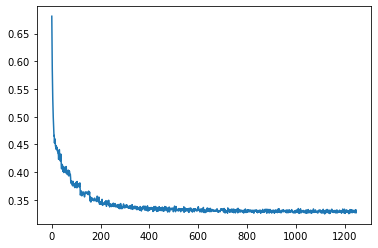

In [41]:
# изменение значения потери в процессе обучения
plt.plot(hist)

In [42]:
# 200 % 100

## тест

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [44]:
from torchtext.data import Iterator

test_iterator = Iterator(
    test_ds, 
    batch_size = 4096, 
    device=device,
    sort=False, 
    shuffle=False,
)

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [45]:
label = []
score = []

with torch.no_grad():
    for batch in test_iterator:
        y_pred = model(batch.text) # вычисляем значения регресии
        y = batch.label
        label.append( y.cpu().detach().numpy() )
        score.append( y_pred.cpu().detach().numpy() )

/usr/lib/python3.9/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [46]:
label = np.hstack(label)
score = np.vstack(score)

In [47]:
y_pred = np.argmax( score ,axis=1)

In [48]:
accuracy_score(label, y_pred)

0.8992505510653931

In [49]:
print(classification_report(label, y_pred) )

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     33525
           1       0.90      0.90      0.90     34525

    accuracy                           0.90     68050
   macro avg       0.90      0.90      0.90     68050
weighted avg       0.90      0.90      0.90     68050

